In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns



In [1]:
from sklearn.datasets import load_iris
import pandas as pd

# Load iris from sklearn
iris = load_iris(as_frame=True)

# Features and target
X = iris.data
y = iris.target

# Combine into one DataFrame
df = X.copy()
df['target'] = y

print(df.head())


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [2]:

# Map class labels to numbers
df['target'] = df['target'].map({
    "Iris-setosa":0,
    "Iris-versicolor":1,
    "Iris-virginica":2
})

# Check for missing values
print("Missing values:\n", df.isna().sum())

# Features and target
X = df.drop(columns=['target'])
y = df['target']



Missing values:
 sepal length (cm)      0
sepal width (cm)       0
petal length (cm)      0
petal width (cm)       0
target               150
dtype: int64


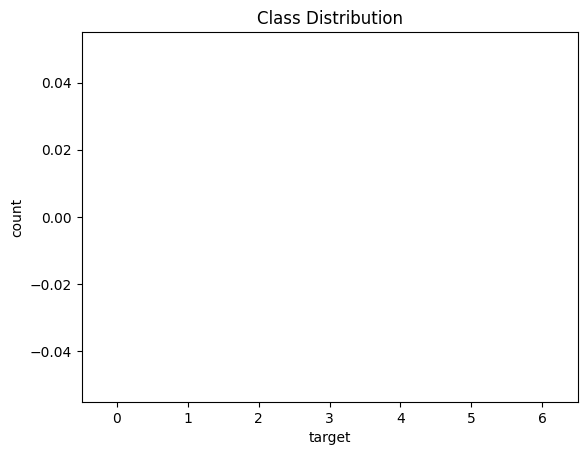

Class counts:
 Series([], Name: count, dtype: int64)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,0.0
mean,5.843333,3.057333,3.758000,1.199333,NaN
std,0.828066,0.435866,1.765298,0.762238,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN
max,7.900000,4.400000,6.900000,2.500000,NaN


In [5]:
# Class distribution
sns.countplot(x=y.map({0:"setosa",1:"versicolor",2:"virginica"}))
plt.title("Class Distribution")
plt.show()

print("Class counts:\n", y.value_counts())

# Summary stats
df.describe()



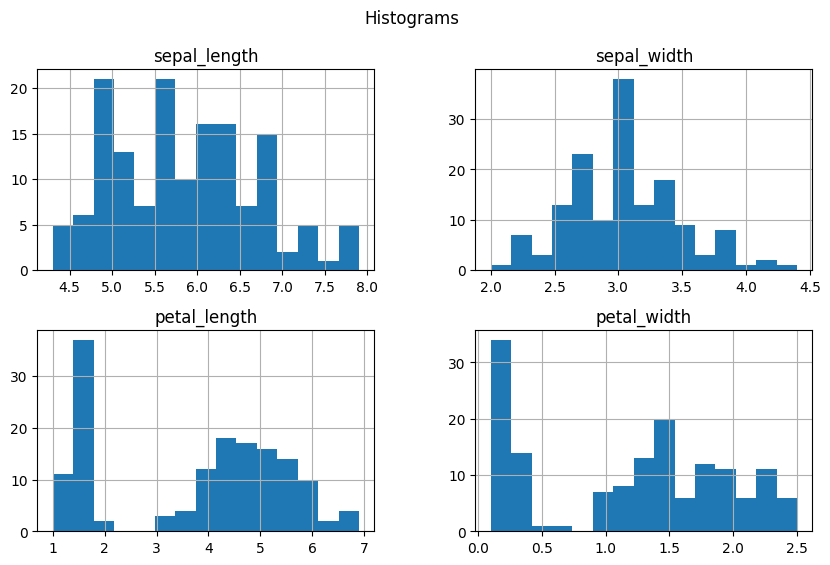

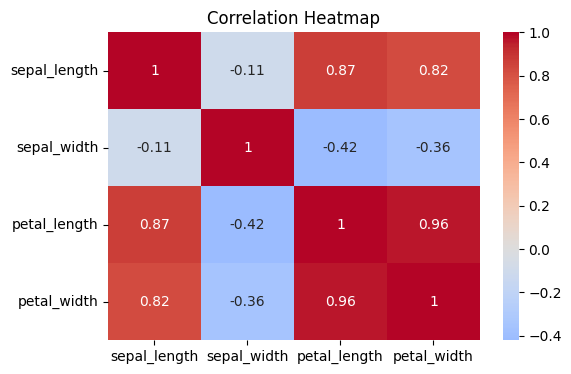

In [ ]:
# Histograms
df[X.columns].hist(bins=15, figsize=(10,6))
plt.suptitle("Histograms")
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df[X.columns].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)


In [ ]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, multi_class='ovr', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM_RBF": SVC(kernel='rbf', probability=True, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_sc, y_train)
    print(f"{name} trained.")



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression trained.
RandomForest trained.
SVM_RBF trained.


In [ ]:
def evaluate(model, X_test, y_test):
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)
    return {
        "Accuracy": accuracy_score(y_test, pred),
        "Precision_macro": precision_score(y_test, pred, average='macro'),
        "Recall_macro": recall_score(y_test, pred, average='macro'),
        "F1_macro": f1_score(y_test, pred, average='macro'),
        "AUC_macro": roc_auc_score(
            label_binarize(y_test, classes=[0,1,2]), proba, multi_class="ovr", average="macro"
        )
    }, pred, proba

results, preds, probas = {}, {}, {}

for name, model in models.items():
    res, p, pr = evaluate(model, X_test_sc, y_test)
    results[name] = res
    preds[name] = p
    probas[name] = pr

metrics_df = pd.DataFrame(results).T
metrics_df



,Accuracy,Precision_macro,Recall_macro,F1_macro,AUC_macro
LogisticRegression,0.900000,0.902357,0.900000,0.899749,0.985000
RandomForest,0.900000,0.902357,0.900000,0.899749,0.986667
SVM_RBF,0.966667,0.969697,0.966667,0.966583,0.996667


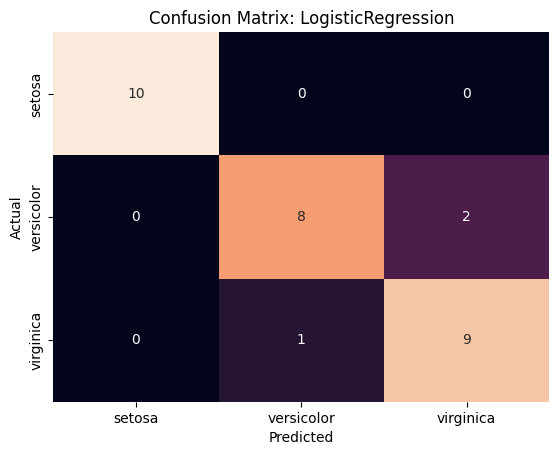

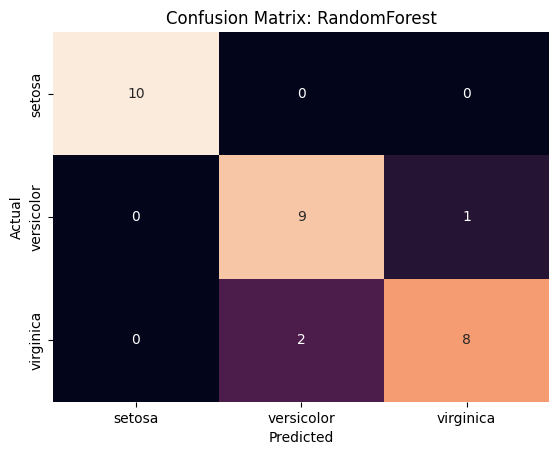

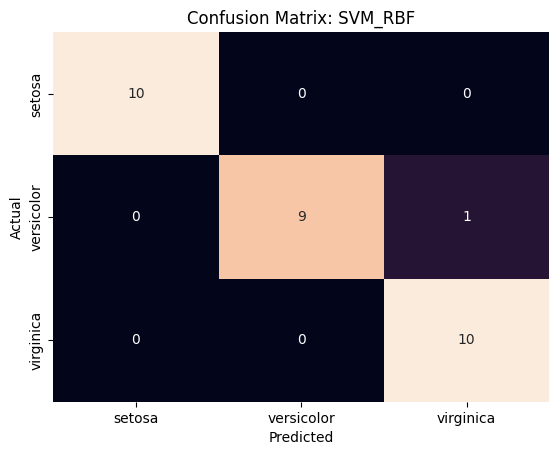

In [ ]:
for name in models:
    cm = confusion_matrix(y_test, preds[name])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cbar=False,
                xticklabels=["setosa","versicolor","virginica"],
                yticklabels=["setosa","versicolor","virginica"])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


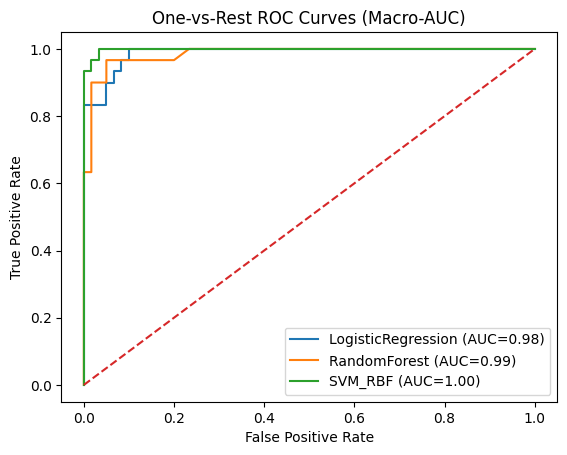

In [ ]:
n_classes = 3
y_test_bin = label_binarize(y_test, classes=[0,1,2])

plt.figure()
for name in models:
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), probas[name].ravel())
    plt.plot(fpr, tpr, label=f"{name} (AUC={metrics_df.loc[name,'AUC_macro']:.2f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves (Macro-AUC)")
plt.legend()
plt.show()

